In [9]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

db_filename = 'northwind.db'  # make sure this file is in the same directory


In [10]:
SQL = """
WITH MonthlySales AS (
    SELECT 
        STRFTIME('%Y-%m', O.OrderDate) AS YearMonth,
        SUM(OD.UnitPrice * OD.Quantity * (1 - OD.Discount)) AS TotalSales
    FROM [Order Details] OD
    JOIN Orders O ON OD.OrderID = O.OrderID
    GROUP BY STRFTIME('%Y-%m', O.OrderDate)
)
SELECT 
    YearMonth,
    TotalSales,
    ROUND(
      100.0 * (TotalSales - LAG(TotalSales) OVER (ORDER BY YearMonth))
      / LAG(TotalSales) OVER (ORDER BY YearMonth)
    , 2) AS MoMGrowthPercent
FROM MonthlySales
ORDER BY YearMonth;
"""

with sqlite3.connect(db_filename) as conn:
    df = pd.read_sql_query(SQL, conn)

df['YearMonth'] = pd.PeriodIndex(df['YearMonth'], freq='M').to_timestamp()
df['TotalSales'] = pd.to_numeric(df['TotalSales'])
df.head()


,YearMonth,TotalSales,MoMGrowthPercent
0,2012-07-01,2066219.40,NaN
1,2012-08-01,3556875.79,72.14
2,2012-09-01,3440144.98,-3.28
3,2012-10-01,3201529.96,-6.94
4,2012-11-01,2980494.74,-6.90


In [11]:
!pip install xlsxwriter


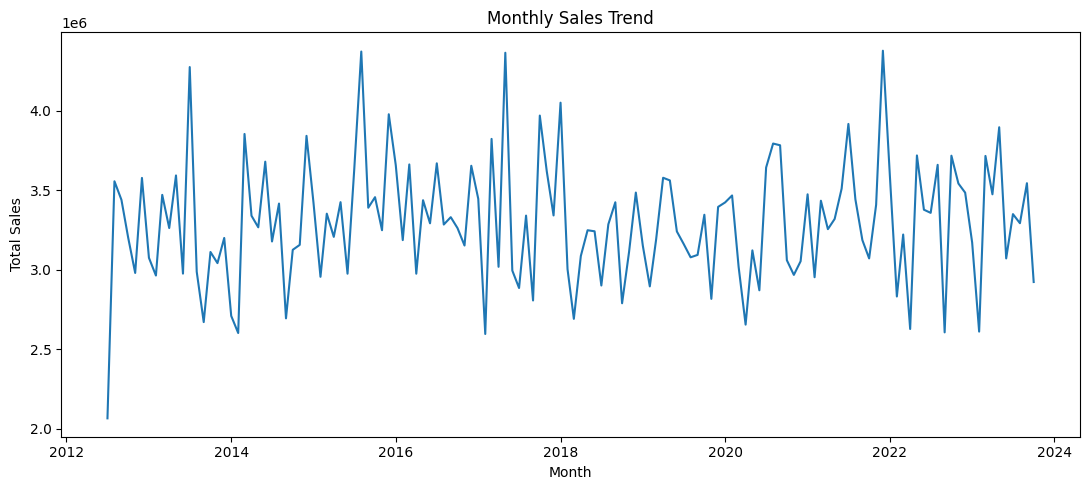

In [12]:
csv_path = 'monthly_sales_trend.csv'
xlsx_path = 'monthly_sales_trend.xlsx'
img_path = 'monthly_sales_trend.png'

df.to_csv(csv_path, index=False)
with pd.ExcelWriter(xlsx_path, engine='xlsxwriter') as writer:
    df.to_excel(writer, sheet_name='MonthlyTrend', index=False)

plt.figure(figsize=(11, 5))
plt.plot(df['YearMonth'], df['TotalSales'])
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.savefig(img_path, dpi=200)
plt.show()


In [13]:
SQL_part3 = """
WITH ProductSales AS (
    SELECT 
        P.ProductID,
        P.ProductName,
        P.CategoryID,
        C.CategoryName,
        SUM(OD.Quantity) AS UnitsSold,
        SUM(OD.UnitPrice * OD.Quantity * (1 - OD.Discount)) AS TotalSales
    FROM [Order Details] OD
    JOIN Products P ON OD.ProductID = P.ProductID
    JOIN Categories C ON P.CategoryID = C.CategoryID
    GROUP BY P.ProductID, P.ProductName, P.CategoryID, C.CategoryName
),
RankedProducts AS (
    SELECT 
        *,
        RANK() OVER (PARTITION BY CategoryID ORDER BY TotalSales DESC) AS CategoryRank
    FROM ProductSales
)
SELECT 
    ProductID,
    ProductName,
    CategoryID,
    CategoryName,
    UnitsSold,
    TotalSales,
    CategoryRank
FROM RankedProducts
ORDER BY CategoryName, CategoryRank;
"""

with sqlite3.connect(db_filename) as conn:
    df_part3 = pd.read_sql_query(SQL_part3, conn)

df_part3['TotalSales'] = pd.to_numeric(df_part3['TotalSales'])
df_part3.head()


,ProductID,ProductName,CategoryID,CategoryName,UnitsSold,TotalSales,CategoryRank
0,38,Côte de Blaye,1,Beverages,202234,5.326590e+07,1
1,43,Ipoh Coffee,1,Beverages,202968,9.333375e+06,2
2,2,Chang,1,Beverages,201802,3.830511e+06,3
3,35,Steeleye Stout,1,Beverages,202366,3.640338e+06,4
4,39,Chartreuse verte,1,Beverages,202017,3.634327e+06,5


In [14]:
csv_part3 = 'product_sales_ranking_by_category.csv'
xlsx_part3 = 'product_sales_ranking_by_category.xlsx'

df_part3.to_csv(csv_part3, index=False)
with pd.ExcelWriter(xlsx_part3) as writer:
    df_part3.to_excel(writer, sheet_name='ProductRanking', index=False)

csv_part3, xlsx_part3


('product_sales_ranking_by_category.csv',
 'product_sales_ranking_by_category.xlsx')

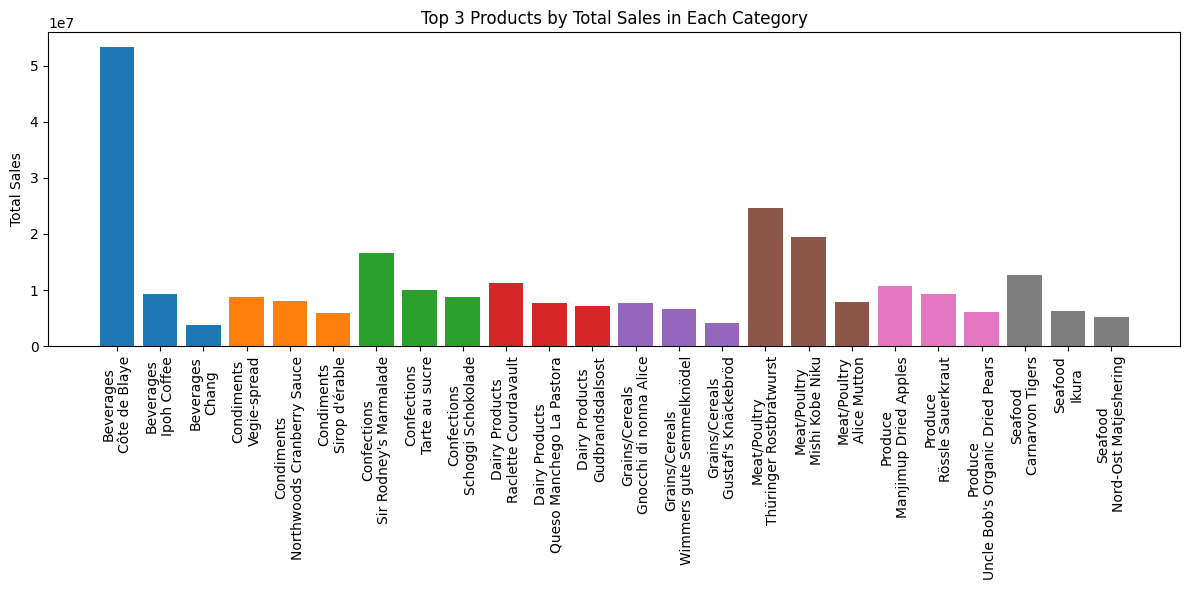

In [15]:
top3_per_cat = (
    df_part3[df_part3['CategoryRank'] <= 3]
    .sort_values(['CategoryName', 'CategoryRank'])
)

plt.figure(figsize=(12, 6))
for category in top3_per_cat['CategoryName'].unique():
    subset = top3_per_cat[top3_per_cat['CategoryName'] == category]
    plt.bar(
        [f"{category}\n{p}" for p in subset['ProductName']],
        subset['TotalSales'],
        label=category
    )

plt.title('Top 3 Products by Total Sales in Each Category')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('product_sales_ranking_chart.png', dpi=200)
plt.show()
